In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
from src.data import IFCNetPlySparse
from src.models.models import MinkowskiPointNet
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn.functional as F
import sklearn.metrics as metrics
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import MinkowskiEngine as ME

In [3]:
data_root = Path("../data/processed/IFCGeom/IFCNetCore")

with open("../IFCNetCore_Classes.json", "r") as f:
    class_names = json.load(f)

In [4]:
train_dataset = IFCNetPlySparse(data_root, class_names, partition="train")
val_dataset = IFCNetPlySparse(data_root, class_names, partition="train")
test_dataset = IFCNetPlySparse(data_root, class_names, partition="test")

np.random.seed(42)
perm = np.random.permutation(range(len(train_dataset)))
train_len = int(0.7 * len(train_dataset))
train_dataset = Subset(train_dataset, sorted(perm[:train_len]))
val_dataset = Subset(val_dataset, sorted(perm[train_len:]))

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=8, num_workers=8, collate_fn=ME.utils.SparseCollation())
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=8, collate_fn=ME.utils.SparseCollation())
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=8, collate_fn=ME.utils.SparseCollation())

In [5]:
#model_dir = Path("../models/")
#with (model_dir/"DGCNNParams.json").open("r") as f:
#    config = json.load(f)

model = MinkowskiPointNet(len(class_names))
#model_state, _ = torch.load(model_dir/"DGCNNWeights+Optimizer")
#model.load_state_dict(model_state)

In [6]:
device = torch.device("cuda")
model.eval()
model.to(device)

MinkowskiPointNet(
  (conv1): Sequential(
    (0): MinkowskiLinear(in_features=3, out_features=64, bias=False)
    (1): MinkowskiBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiReLU()
  )
  (conv2): Sequential(
    (0): MinkowskiLinear(in_features=64, out_features=64, bias=False)
    (1): MinkowskiBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiReLU()
  )
  (conv3): Sequential(
    (0): MinkowskiLinear(in_features=64, out_features=64, bias=False)
    (1): MinkowskiBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiReLU()
  )
  (conv4): Sequential(
    (0): MinkowskiLinear(in_features=64, out_features=128, bias=False)
    (1): MinkowskiBatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiReLU()
  )
  (conv5): Sequential(
    (0): MinkowskiLinear(in_features=128, out_features=1024, bias=False)
    (1): Min

In [7]:
def calc_metrics(probabilities, labels):
    predictions = np.argmax(probabilities, axis=1)

    acc = metrics.accuracy_score(labels, predictions)
    balanced_acc = metrics.balanced_accuracy_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions, average="weighted")
    recall = metrics.recall_score(labels, predictions, average="weighted")
    f1 = metrics.f1_score(labels, predictions, average="weighted")

    return {
        f"accuracy_score": acc,
        f"balanced_accuracy_score": balanced_acc,
        f"precision_score": precision,
        f"recall_score": recall,
        f"f1_score": f1
    }

def plot_confusion_matrix(confusion_matrix, display_labels, fname=None):
    labels = list(map(lambda x: x[3:], display_labels))
    df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    plt.figure(figsize=(7, 5))
    heatmap = sn.heatmap(df, cmap="Blues", annot=True, fmt="d", cbar=False)
    plt.ylabel("Actual class")
    plt.xlabel("Predicted class")
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")

def eval(model, loader, device, class_names, fname=None):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for coords, feats, labels in tqdm(loader):
            labels = torch.tensor(labels)
            coords, feats, labels = coords.to(device), feats.to(device), labels.to(device)
            tensor = ME.SparseTensor(feats, coords)

            outputs = model(tensor)

            probs = F.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    result = calc_metrics(all_probs, all_labels)
    predictions = np.argmax(all_probs, axis=1)
    confusion_matrix = metrics.confusion_matrix(all_labels, predictions)
    plot_confusion_matrix(confusion_matrix, class_names, fname=fname)
    return all_labels, all_probs

100%|██████████| 486/486 [00:09<00:00, 49.66it/s]
/home/ce/anaconda3/envs/ifcnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([11,  3,  5, ..., 10,  2, 10]),
 array([[0.04806889, 0.05088232, 0.05163404, ..., 0.05026123, 0.05003161,
         0.04803826],
        [0.04816166, 0.05094887, 0.05144976, ..., 0.05004217, 0.05032782,
         0.04795247],
        [0.04814095, 0.05069536, 0.05153466, ..., 0.05021037, 0.0499936 ,
         0.04797242],
        ...,
        [0.04815051, 0.05066952, 0.05153682, ..., 0.05021774, 0.04995967,
         0.04797217],
        [0.04815483, 0.05065804, 0.05152582, ..., 0.05021181, 0.04995501,
         0.04796447],
        [0.04815495, 0.05064857, 0.05152485, ..., 0.05021395, 0.04994527,
         0.04796454]], dtype=float32))

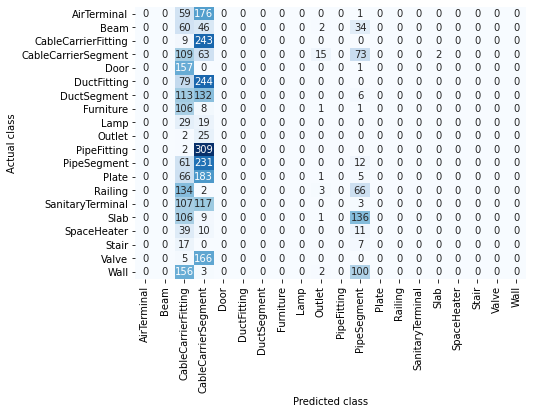

In [8]:
eval(model, train_loader, device, class_names)

In [ ]:
eval(model, val_loader, device, class_names)

In [ ]:
test_labels, test_probs = eval(model, test_loader, device,
                               class_names, fname="../reports/figures/dgcnn_confusion.png")

In [ ]:
np.savez("DGCNNProbs.npz", labels=test_labels, probs=test_probs)

In [ ]:
test_predictions = np.argmax(test_probs, axis=1)
wrong_predictions = np.where(test_labels != test_predictions)[0]

In [ ]:
wrong_pred_dir = Path("../data/external/DGCNN/wrong_classes/IFCNetCore")
raw_data_dict = {path.stem: path for path in Path("../data/raw/IFCNetCore").glob("**/test/*.obj")}
wrong_pred_dir.mkdir(parents=True, exist_ok=True)
for i in wrong_predictions:
    label_str = class_names[test_labels[i]]
    prediction_str = class_names[test_predictions[i]]
    print(f"{test_dataset.files[i].stem}, Label: {label_str}, Prediction: {prediction_str}")
    target_dir = wrong_pred_dir / label_str
    target_dir.mkdir(exist_ok=True)
    filename = test_dataset.files[i]
    shutil.copy(str(raw_data_dict[filename.stem]), str(target_dir / f"{filename.stem}_{prediction_str}.obj"))